# Performance of Permutations, Additions, Deletions

We'll perform experiments on Rips complex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bats
import time

In [2]:
def print_UI(UI):
    print("UpdateInformation: ", UI)
    print("kt-dists", *UI.kendall_tau_dists)
    print("additions: ", *(len(idxs) for idxs in UI.addition_indices))
    print("deletions: ", *(len(idxs) for idxs in UI.deletion_indices))
    
def barcodes_identical(ps0, ps1):
    ident = True
    for p, q in zip(ps0, ps1):
        ident = ident and\
        p.dim() == q.dim() and\
        p.birth() == q.birth() and\
        p.death() == q.death() and\
        p.birth_ind() == q.birth_ind() and\
        p.death_ind() == q.death_ind()
        
    return ident

import hera_tda as hera
def bottleneck_max(ps0, ps1, dmax=1):
    dist = 0
    for dim in range(dmax+1):
        ps0a = [p for p in ps0 if p.dim() == dim and p.length() > 0]
        ps1a = [p for p in ps1 if p.dim() == dim and p.length() > 0]
        dist += hera.BottleneckDistance(ps0a, ps1a)[0]
        
    return dist

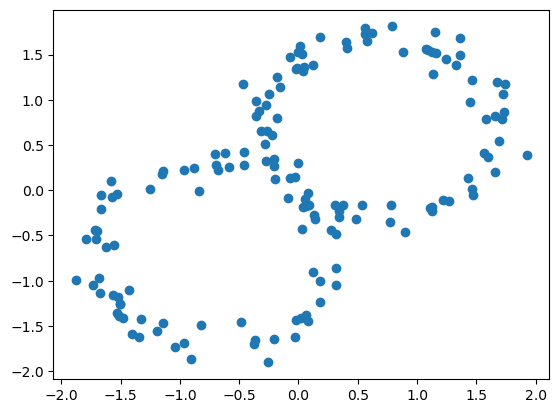

In [3]:
def gen_fig_8(n, r=1.0, sigma=0.1):
    X = np.random.randn(n,2)
    X = r * X / np.linalg.norm(X, axis=1).reshape(-1,1)
    X += sigma*np.random.randn(n, 2) + np.random.choice([-1/np.sqrt(2),1/np.sqrt(2)], size=(n,1))
    return X

np.random.seed(0)
n = 150
X = gen_fig_8(n)

plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
R = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), np.inf, 2)

In [5]:
t0 = time.monotonic()
RC = bats.reduce(R, bats.F2(), bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print(t1 - t0, ' sec.')

2.2211047540185973  sec.


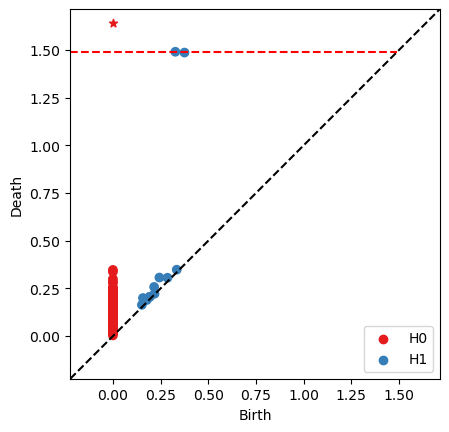

In [6]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

# Additions

We'll explore the effect of the number of additions to R

In [4]:
t0 = time.monotonic()
r0 = 2.0
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r0, 2)
t1 = time.monotonic()
print(t1 - t0)

t0 = time.monotonic()
r1 = 2.2
R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r1, 2)
t1 = time.monotonic()
print(t1 - t0)

0.33263821504078805
0.4873376110335812


In [5]:
t0 = time.monotonic()
U01 = bats.UpdateInfoFiltration(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.2112966029671952


In [12]:
t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.170787148992531


In [7]:
print([len(inds) for inds in U.insertion_indices])
print([len(inds) for inds in U01.addition_indices])

print([inds for inds in U.ndeletions])
print([len(inds) for inds in U01.deletion_indices])

[0, 1033, 70327]
[0, 1033, 70327]
[0, 0, 0]
[0, 0, 0]


In [15]:
degree = -1

t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R0: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R1: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print("updateinfo: ", t1 - t0)

R0: 0.88 sec.
R1: 1.39 sec.
updateinfo:  0.16750528302509338


In [16]:
t0 = time.monotonic()
RC0.update(U)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 0.59 sec.


In [9]:
# run this or above
t0 = time.monotonic()
RC0.update_filtration_general(U01)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 3.32 sec.


bottleneck dist =  0.0


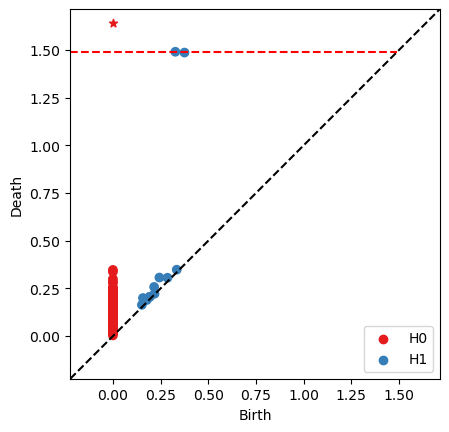

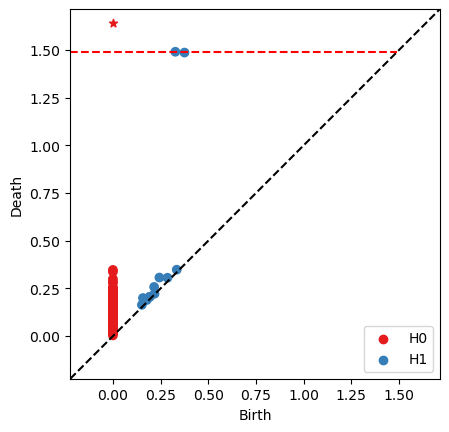

In [17]:
ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

print("bottleneck dist = ", bottleneck_max(ps0, ps1))

bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()

In [7]:
degree = -1 # degree +1 is very slow

r0 = 2.0
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r0, 2)
rs = np.linspace(2.05, 4.5, 5)
rs = [2.01, 2.02, 2.03, 2.04, 2.05, 2.10 ,*np.linspace(2.2, 4.5, 5)]
t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
tcomp0 = t1 - t0

adds = []
tadd = []
tcomp = []

for r in rs:
    # recompute for update
    RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
    
    R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
    
    # time update
    t0 = time.monotonic()
    U01 = bats.UpdateInfoFiltration(R0, R1)
    RC0.update_filtration_general(U01)
    t1 = time.monotonic()
    tadd.append(t1 - t0)
    
    # time recompute
    t0 = time.monotonic()
    DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
    RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    tcomp.append(t1 - t0)
    
    ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
    ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)
    
    # print_UI(U01)
    adds.append(sum(len(idxs) for idxs in U01.addition_indices))
    print("r = {:.2f},\t nadded = {:07d},\t tup = {:.4f},\t tcomp = {:.4f},\t init+up = {:.4f}\t{}".format(
        r, adds[-1], tadd[-1], tcomp[-1], tadd[-1]+tcomp0, bottleneck_max(ps0, ps1)))

r = 2.01,	 nadded = 0005402,	 tup = 0.2380,	 tcomp = 0.5617,	 init+up = 0.7905	0.0
r = 2.02,	 nadded = 0009404,	 tup = 0.2835,	 tcomp = 0.6844,	 init+up = 0.8361	0.0
r = 2.03,	 nadded = 0013525,	 tup = 0.3044,	 tcomp = 0.5844,	 init+up = 0.8569	0.0
r = 2.04,	 nadded = 0018029,	 tup = 0.3220,	 tcomp = 0.6203,	 init+up = 0.8745	0.0
r = 2.05,	 nadded = 0021375,	 tup = 0.3348,	 tcomp = 0.6606,	 init+up = 0.8874	0.0
r = 2.10,	 nadded = 0040645,	 tup = 0.4471,	 tcomp = 0.7367,	 init+up = 0.9997	0.0
r = 2.20,	 nadded = 0071360,	 tup = 0.5931,	 tcomp = 0.8833,	 init+up = 1.1457	0.0
r = 2.78,	 nadded = 0168059,	 tup = 0.9662,	 tcomp = 1.3024,	 init+up = 1.5188	0.0
r = 3.35,	 nadded = 0259981,	 tup = 1.3088,	 tcomp = 1.6469,	 init+up = 1.8613	0.0
r = 3.92,	 nadded = 0357624,	 tup = 1.8207,	 tcomp = 2.1281,	 init+up = 2.3733	0.0
r = 4.50,	 nadded = 0381167,	 tup = 1.9805,	 tcomp = 2.1738,	 init+up = 2.5331	0.0


# Permutations

In [18]:
def normalized_kt(U, X):
    """
    Compute normalized kendall-tau distance given update information U and starting filtration X
    """
    k = 0
    maxk = 0
    for d in range(X.maxdim() + 1):
        nd = X.ncells(d)
        maxk += (nd * (nd - 1)) // 2
        k += U.kendall_tau_dists[d]
        
    return k / maxk

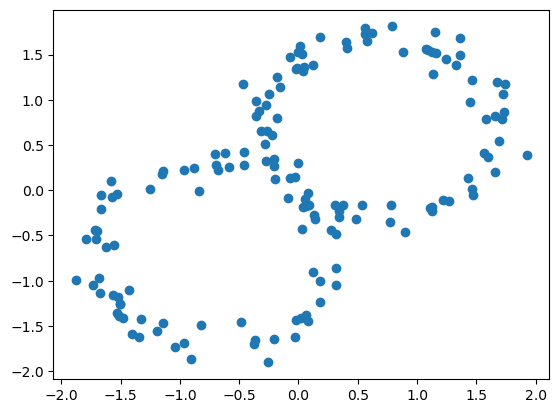

In [19]:
np.random.seed(0)
n = 150
X = gen_fig_8(n)
noise = np.random.normal(size=X.shape)

plt.scatter(X[:,0], X[:,1])
plt.show()

In [20]:
r = np.inf
Y = X + 0.1*noise
t0 = time.monotonic()
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
t1 = time.monotonic()
print(t1 - t0)

t0 = time.monotonic()
R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), r, 2)
t1 = time.monotonic()
print(t1 - t0)

1.102771008037962
1.0627670630346984


In [21]:
t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.3570580680388957


In [22]:
t0 = time.monotonic()
U01 = bats.UpdateInfoFiltration(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.5476762909675017


In [31]:
degree = -1

t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R0: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R1: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print("update2 construction ", t1 - t0)

R0: 3.24 sec.
R1: 3.62 sec.
update2 construction  0.3813020790112205


In [24]:
t0 = time.monotonic()
RC0.update_filtration_general(U01)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 0.37 sec.


In [32]:
t0 = time.monotonic()
RC0.update(U)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 0.48 sec.


bottleneck dist =  0.0


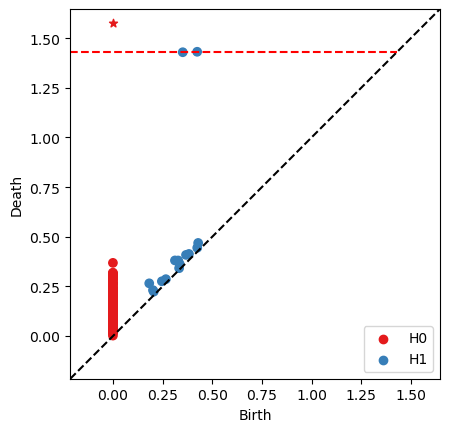

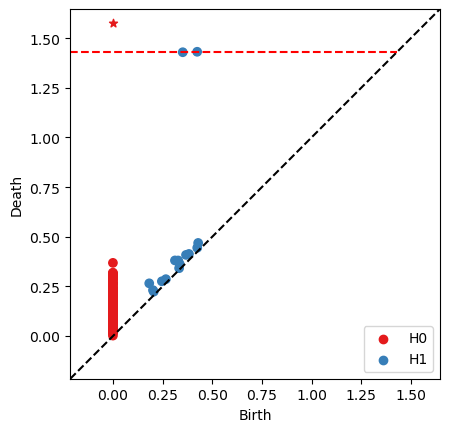

In [33]:
ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

print("bottleneck dist = ", bottleneck_max(ps0, ps1))

bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()

In [31]:
degree = -1

r = np.inf
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
tcomp0 = t1 - t0

dists = []
tperm = []
tcomp = []

for sigma in [0.01, 0.1]:
    
    # recompute from scratch
    RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())

    Y = X + sigma*noise
    R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), r, 2)

    # time update
    t0 = time.monotonic()
    U01 = bats.UpdateInfoFiltration(R0, R1)
    RC0.update_filtration_general(U01)
    t1 = time.monotonic()
    tperm.append(t1 - t0)

    # time recompute
    t0 = time.monotonic()
    DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
    RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    tcomp.append(t1 - t0)

    ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
    ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

    dists.append(normalized_kt(U01, R0))
    print("sigma = {:.2f},\t dperm = {:.3f},\t tup = {:.4f},\t tcomp = {:.4f},\t init+up = {:.4f}\t{}".format(
            sigma, dists[-1], tperm[-1], tcomp[-1], tperm[-1]+tcomp0, bottleneck_max(ps0, ps1)))


sigma = 0.01,	 dperm = 0.005,	 tup = 0.5946,	 tcomp = 1.9072,	 init+up = 2.5396	0.0
sigma = 0.10,	 dperm = 0.053,	 tup = 0.8271,	 tcomp = 2.3676,	 init+up = 2.7721	0.0


degree +1
```
sigma = 0.01,	 dperm = 0.005,	 tup = 0.5399,	 tcomp = 0.8089,	 init+up = 1.2551	True
sigma = 0.10,	 dperm = 0.053,	 tup = 0.6373,	 tcomp = 0.3767,	 init+up = 1.3525	False
```

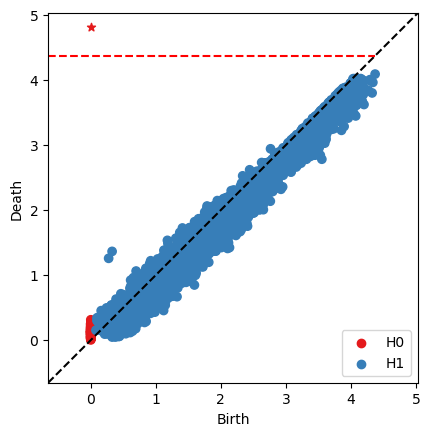

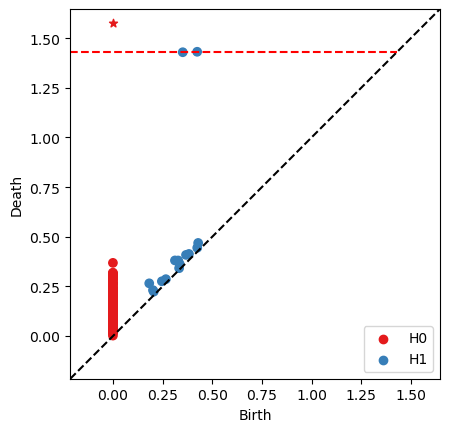

In [12]:
bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()

Trying with chain complexes...

In [13]:
degree = -1

r = np.inf
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
t0 = time.monotonic()
DG0 = bats.FilteredF2ChainComplex(R0)
RC0 = bats.ReducedFilteredF2ChainComplex(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
tcomp0 = t1 - t0

dists = []
tperm = []
tcomp = []

for sigma in [0.01, 0.1]:

    Y = X + sigma*noise
    R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), r, 2)

    # time update
    t0 = time.monotonic()
    U01 = bats.UpdateInfoFiltration(R0, R1)
    RC0.update_filtration_general(U01)
    t1 = time.monotonic()
    tperm.append(t1 - t0)

    # time recompute
    t0 = time.monotonic()
    DG1 = bats.FilteredF2ChainComplex(R1)
    RC1 = bats.ReducedFilteredF2ChainComplex(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    tcomp.append(t1 - t0)

    ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
    ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

    dists.append(normalized_kt(U01, R0))
    print("sigma = {:.2f},\t dperm = {:.3f},\t tup = {:.4f},\t tcomp = {:.4f},\t init+up = {:.4f}\t{}".format(
            sigma, dists[-1], tperm[-1], tcomp[-1], tperm[-1]+tcomp0, bottleneck_max(ps0, ps1)))

sigma = 0.01,	 dperm = 0.005,	 tup = 0.7133,	 tcomp = 2.3332,	 init+up = 3.1848	0.0
sigma = 0.10,	 dperm = 0.053,	 tup = 1.3310,	 tcomp = 2.6079,	 init+up = 3.8025	0.26341863268427684


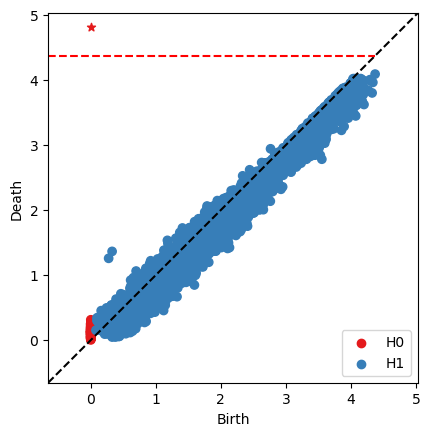

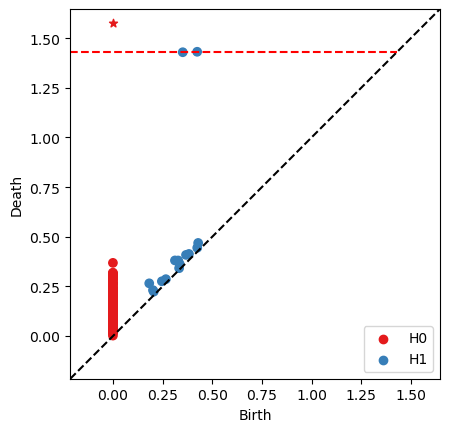

In [14]:
bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()

Let's just try the update method

In [15]:
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), np.inf, 2)

Y = X + 0.1*noise
R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), np.inf, 2)

In [16]:
def get_update_filt(F0, F1):
    X0 = F0.complex()
    X1 = F1.complex()
    
    newvals = []
    for d in range(F0.maxdim() + 1):
        newvals.append(list())
        vals1 = F1.vals(d)
        for s in X0.get_simplices(d):
            s1 = X1.find_idx(s)
            newvals[d].append(vals1[s1])
            
    return newvals

In [17]:
t0 = time.monotonic()
newvals = get_update_filt(R0, R1)
t1 = time.monotonic()
t1 - t0

1.30262914695777

In [18]:
t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
t1 - t0

2.4431137350038625

In [19]:
# time update
t0 = time.monotonic()
RC0.update_filtration(newvals)
t1 = time.monotonic()
t1 - t0

0.40543246298329905

In [20]:
t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
t1 - t0

2.733302963024471

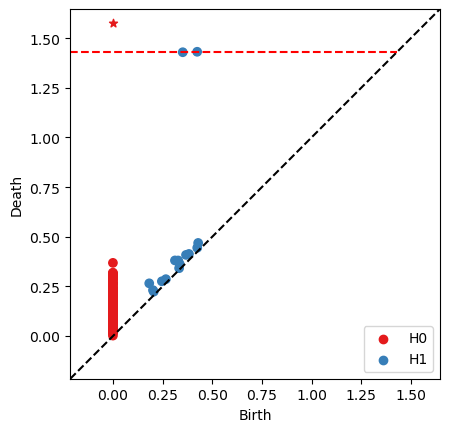

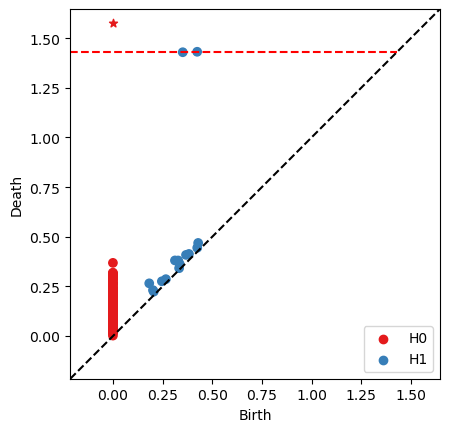

In [21]:
ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()

In [22]:
barcodes_identical(ps0, ps1)

False

In [23]:
bottleneck_max(ps0, ps1)

0.0

# Deletion

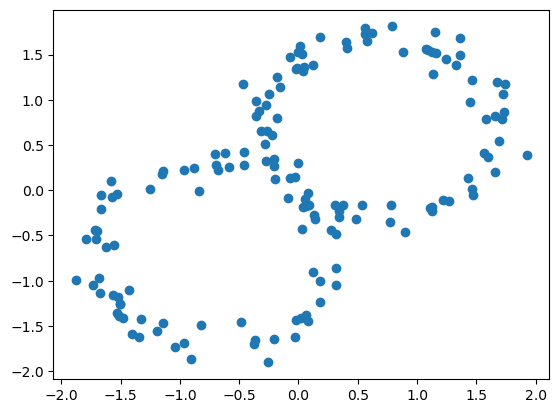

In [34]:
def gen_fig_8(n, r=1.0, sigma=0.1):
    X = np.random.randn(n,2)
    X = r * X / np.linalg.norm(X, axis=1).reshape(-1,1)
    X += sigma*np.random.randn(n, 2) + np.random.choice([-1/np.sqrt(2),1/np.sqrt(2)], size=(n,1))
    return X

np.random.seed(0)
n = 150
X = gen_fig_8(n)

plt.scatter(X[:,0], X[:,1])
plt.show()

In [53]:
t0 = time.monotonic()
r0 = 4.3
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r0, 2)
t1 = time.monotonic()
print(t1 - t0)

t0 = time.monotonic()
r1 = 0.0
R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r1, 2)
t1 = time.monotonic()
print(t1 - t0)

1.1638881930266507
0.010337022016756237


In [54]:
t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.05361722898669541


In [59]:
t0 = time.monotonic()
U01 = bats.UpdateInfoFiltration(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.1217491429997608


In [58]:
degree = +1

t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R0: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R1: {:.2f} sec.".format(t1 - t0))

R0: 0.42 sec.
R1: 0.00 sec.


In [56]:
t0 = time.monotonic()
RC0.update(U)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 0.08 sec.


In [ ]:
t0 = time.monotonic()
RC0.update_filtration_general(U01)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

bottleneck dist =  0.0


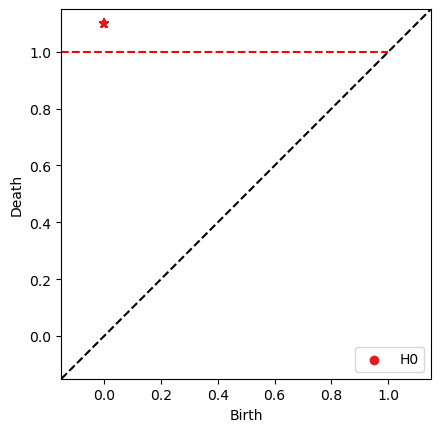

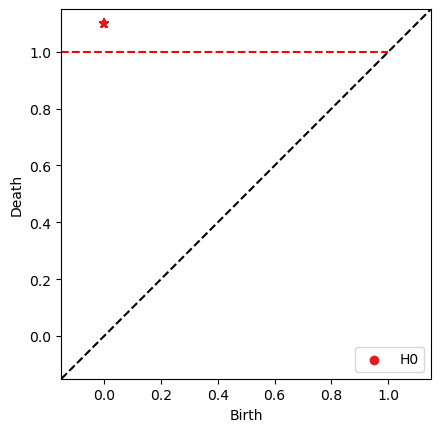

In [57]:
ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

print("bottleneck dist = ", bottleneck_max(ps0, ps1))

bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()

In [ ]:
degree = +1 # +1 crashes

r0 = 4.3
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r0, 2)
rs = np.linspace(2.05, 4.5, 5)
rs = [4.2, 4.15, 4.1, 4.05, 4.0, 3.5, 3.0, 2.5, 2.0, 1.0, 0.0]
t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
tcomp0 = t1 - t0

dels = [] # number deleted
tapp = [] # time for application of update
tdel = [] # time for full deletion
tcomp = [] # time to compute from scratch

for r in rs:
    print(r, flush=True)
    # recompute for update
    RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
    
    R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
    
    # time update
    t0 = time.monotonic()
    U01 = bats.UpdateInfoFiltration(R0, R1)
    t0a = time.monotonic()
    RC0.update_filtration_general(U01)
    t1 = time.monotonic()
    tdel.append(t1 - t0)
    tapp.append(t1 - t0a)
    
    # time recompute
    t0 = time.monotonic()
    DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
    RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    tcomp.append(t1 - t0)
    
    ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
    ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)
    
    # print_UI(U01)
    dels.append(sum(len(idxs) for idxs in U01.deletion_indices))
    print("r = {:.2f},\t ndeleted = {:07d},\t tup = {:.2f}/{:.2f},\t tcomp = {:.4f},\t init+up = {:.4f}\t{}".format(
        r, dels[-1], tdel[-1], tapp[-1], tcomp[-1], tdel[-1]+tcomp0, barcodes_identical(ps0, ps1)))

# Everything at Once

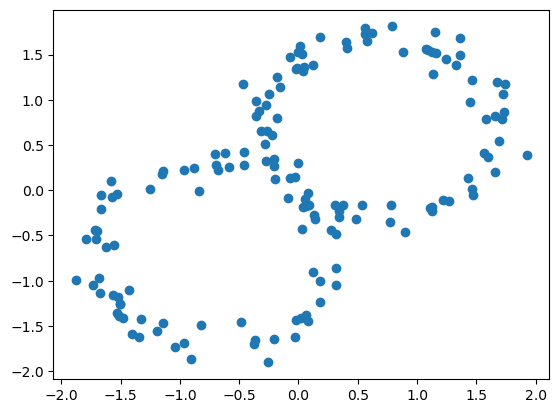

In [4]:
np.random.seed(0)
n = 150
X = gen_fig_8(n)
noise = np.random.normal(size=X.shape)

plt.scatter(X[:,0], X[:,1])
plt.show()

In [6]:
r = 2.0
Y = X + 0.1*noise
t0 = time.monotonic()
R0 = bats.RipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
t1 = time.monotonic()
print(t1 - t0)

t0 = time.monotonic()
R1 = bats.RipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), r, 2)
t1 = time.monotonic()
print(t1 - t0)

0.33280721597839147
0.3067253209883347


In [7]:
t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.10275560599984601


In [13]:
t0 = time.monotonic()
U01 = bats.UpdateInfoFiltration(R0, R1)
t1 = time.monotonic()
print(t1 - t0)

0.18668480502674356


In [11]:
degree = -1

t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R0: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R1: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print("update2 construction ", t1 - t0)

R0: 0.92 sec.
R1: 0.85 sec.
update2 construction  0.11485479201655835


In [14]:
t0 = time.monotonic()
RC0.update_filtration_general(U01)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 0.64 sec.


In [9]:
t0 = time.monotonic()
RC0.update(U)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

update: 0.62 sec.


bottleneck dist =  0.0


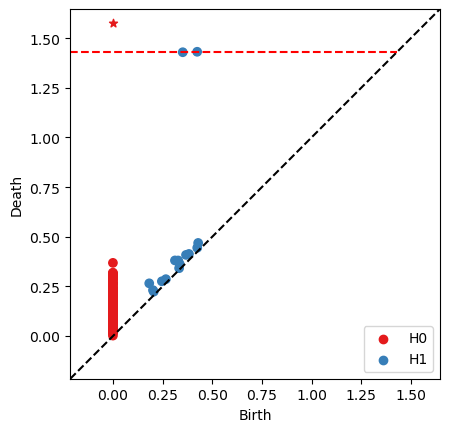

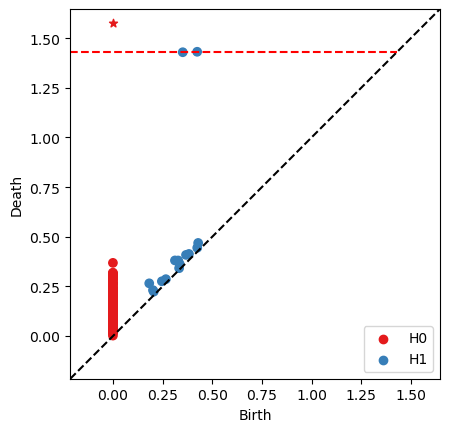

In [15]:
ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

print("bottleneck dist = ", bottleneck_max(ps0, ps1))

bats.persistence_diagram(ps0)
plt.show()

bats.persistence_diagram(ps1)
plt.show()